In [1]:
using LinearAlgebra, Flux, StatsBase, Plots

In [2]:

function perform_action!(state::Vector{Int}, action::Int, player::Int)
    state[action] = player #白を1, 黒を-1とする
end

#終了判定のルール
function finish_pattern(l::Int)
    finish_vec::Vector{Vector{Int}} = []
    #横揃え
    for i in 1:l
        v = zeros(Int, l^2)
        st = l*(i-1)
        v[st+1:st+l] = ones(Int, l)
        push!(finish_vec, v)
    end
    
    #縦揃え
    for i in 1:l
        v = zeros(Int, l^2)
        v[i:l:l^2] = ones(Int, l)
        push!(finish_vec, v)
    end
    
    #斜め揃え
    v1 = vec(Int[(i==j) for i in 1:l, j in 1:l])
    push!(finish_vec, v1)

    v2 = vec(Int[(i+j==4) for i in 1:l, j in 1:l])
    push!(finish_vec, v2)

    return finish_vec
end

#終了判定
function is_finish(state::Vector{Int}, f_vec::Vector{Vector{Int}})
    #勝利条件を満たしていれば終了(true)
    for fv in f_vec
        if(abs(state' * fv) == 3)
            return true
        end
    end
    #まだ空白があれば続行(false)
    for s in state
        if(s==0)
            return false
        end
    end
    #空白がなければ終了(引き分け)
    return true
end

#勝者判定
function whowin(state::Vector{Int}, f_vec::Vector{Vector{Int}})
    for fv in f_vec
        if((state' * fv) > 2)
            return 1
        elseif((state' * fv) < -2)
            return -1
        end
    end
    return 0
end

function show_state(state::Vector{Int}, l::Int)
    for i in 1:l
        println("------")
        for j in 1:l
            print("|")
            if(state[l*(i-1)+j] == 1)
                print("○")
            elseif(state[l*(i-1)+j] == -1)
                print("×")
            else
                print(" ")
            end
        end
        println("|")
    end
    println("------")
end

show_state (generic function with 1 method)

In [3]:
struct AZ_parm
    l::Int #マス目の数
    c_i::Float32 #初期探索確率
    c_b::Int #方策勾配の学習率
    num_simulation::Int #MCTSのシミュレーション回数
    fvs::Vector{Vector{Int}} #終了判定のパターン
    α::Float32 #Dirichlet分布のα
    frac::Float32 #Dirichlet分布の割合
end

function init_AZ_parm(l::Int, c_i::Float32, c_b::Int, num_simulation::Int)
    fvs = finish_pattern(l)
    return AZ_parm(l, c_i, c_b, num_simulation, fvs, 0.3f0, 0.25f0)
end

mutable struct Game
    history::Vector{Int} #Gameの進行手順を記録
    child_visit::Vector{Vector{Float32}} #π(a|s)の標本を格納
    winner::Int #勝者を格納
    winrate::Vector{Float32} #勝率の標本を格納(本来のalphazeroには存在しない)
end

function hist2state(hist::Vector{Int}, l::Int)
    state = zeros(Int, l^2)
    for (i,a) in enumerate(hist)
        state[a] = (-1)^(i+1)
    end
    return state
end

hist2state (generic function with 1 method)

In [4]:
function logvec(vs)
    return [log(v) for v in vs]
end

logvec (generic function with 1 method)

In [5]:
mutable struct Node
    m::Int #訪問回数
    p::Float32
    val_sum::Float32
    child::Dict{Int, Node}
    player::Int
end

function init_node(init_q::Float32, p::Float32, player::Int)
    return Node(0, p, init_q, Dict(), player)
end

#打てる場所を探す
function legal_action(state::Vector{Int})
    return findall(x->x==0, state)
end

legal_action (generic function with 1 method)

In [20]:
#NNから評価値を計算し、子ノードを展開
function evaluate(node::Node, model::Chain, state::Vector{Int})
    if(node.m > 0)
        return node.val_sum/node.m
    end
    l = length(state)
    s0 = zeros(Float32, l,1)
    s0[:,1] = state
    polv = model(s0)
    #println(length(polv))
    v = polv[end,1]

    la = legal_action(state)
    if(isempty(la))
        return v
    else
        pol = [polv[i,1] for i in la]
        policy = softmax(pol)
        for (i,a) in enumerate(la)
            node.child[a] = init_node(0.0f0, policy[i], -node.player)
        end
    end
    return v
end

#ucb
function calc_ucb(par::AZ_parm, node::Node, action::Int)
    child = node.child[action]
    c_puct = log((node.m+par.c_b+1)/par.c_b) + par.c_i
    if(child.m == 0)
        return c_puct * child.p * sqrt(node.m)
    end
    return child.val_sum/child.m + c_puct * child.p * sqrt(node.m)/(1 + child.m)
end

#UCBに従い子ノードを選択(シュミレーション)
function select_child(par::AZ_parm, node::Node)
    legal_actions = Int.(keys(node.child))
    vals = [calc_ucb(par, node, a) for a in legal_actions]
    inds = findall(x -> x==maximum(vals), vals)
    ind = rand(inds)
    action = legal_actions[ind]
    #println("action: $(action), legal_action: $(legal_actions)")
    return action, node.child[action]
end

#最も訪問回数の多い子ノードを選択(本番行動)
function select_action(root::Node)
    actions = Int.(keys(root.child))
    #AlphaZeroだとゲームの経過ターン数が少ない時はsoftmaxで手を決める。これは将棋等のゲームでは、序盤の手を広げて探索するためであろう。今回の丸罰ゲームはそもそも最大ターン数が９なのでやらなくてもいいはずであり、省略した。
    visit_counts = [root.child[a].m for a in actions]
    return actions[argmax(visit_counts)]
end

select_action (generic function with 1 method)

In [25]:
#終局までシュミレーション結果を木の根元に遡って反映

function back_prop!(root::Node, scratch_hist::Vector{Int}, v::Float32)
    player = (-1)^(length(scratch_hist))
    node = root
    #println(node.child)
    for a in scratch_hist
        #println(Int.(keys(node.child)))
        node = node.child[a]
        node.m += 1
        if(node.player == player)
            node.val_sum += v
        else
            node.val_sum += -v
        end
    end
end

function winner2v(winner::Int, player::Int)
    if(winner == player)
        return -1.0f0
        #return 1.0f0
    elseif(winner == -player)
        return 1.0f0
        #return -1.0f0
    else
        return 0.0f0
    end
end

function back_prop!(root::Node, scratch_hist::Vector{Int}, winner::Int)
    node = root
    node.m += 1
    node.val_sum += Float32(winner2v(winner, node.player))
    for a in scratch_hist
        node = node.child[a]
        node.m += 1
        node.val_sum += Float32(winner2v(winner, node.player))
    end
end

back_prop! (generic function with 2 methods)

In [8]:
using Distributions
# 探索のためのノイズ付与(徐々に小さくしていく)
function add_exploration_noise!(p::AZ_parm, node::Node, ratio::Float32)
    actions = Int.(keys(node.child))
    l = length(actions)
    noise = rand(Dirichlet(p.α * ones(Float32, l)))
    for it in 1:l
        node.child[actions[it]].p = node.child[actions[it]].p * (1-ratio*p.frac) + noise[it] * ratio* p.frac
    end
end

add_exploration_noise! (generic function with 1 method)

In [9]:
#MCTSの実行(シミュレーションを実行し、次の1手を決める)
function run_mcts(p::AZ_parm, model::Chain, game::Game, n_ratio::Float32)
    root = init_node(0.0f0, 1.0f0, (-1)^(length(game.history)))
    
    state = hist2state(game.history, p.l)
    v0 = evaluate(root, model, state)
    add_exploration_noise!(p, root, n_ratio)
    
    for i in 1:p.num_simulation
        node = root
        scratch_hist = deepcopy(game.history)
        state = hist2state(scratch_hist, p.l)
        additional_hist = Int[]
        #serach_path::Vector{Node} = [node]
        while(true)
            if(isempty(node.child)||is_finish(state, p.fvs))
                break
            else
                action, node = select_child(p, node)
                push!(scratch_hist, action)
                push!(additional_hist, action)
                state = hist2state(scratch_hist, p.l)
                v = evaluate(node, model, state)
            end
        end
        
        #back_prop!(serach_path, v, (-1)^(length(scratch_hist)))
        #back_prop!(root, additional_hist, v)
        winner = whowin(state, p.fvs)
        back_prop!(root, additional_hist, winner)
    end
    #これは本来のalphazeroには存在しない
    #winrate = root.val_sum/root.m
    return select_action(root), root
end

#MCTSを使って終局までゲームをプレイ
function play_game(p::AZ_parm, model::Chain, n_ratio::Float32)
    game = Game([], [], 0, [])
    while(true)
        action, root = run_mcts(p, model, game, n_ratio)
        push!(game.history, action)
        push!(game.winrate, root.val_sum/root.m)
        
        visits = zeros(Float32, p.l^2)
        for a in keys(root.child)
            visits[a] = (root.child[a]).m
        end
        
        push!(game.child_visit, visits./sum(visits))
        #println(visits)
        state = hist2state(game.history, p.l)
        if(is_finish(state, p.fvs))
            game.winner = whowin(state, p.fvs)
            break
        end
    end
    return game
end

function run_selfplay(p::AZ_parm, model::Chain, N::Int, n_ratio::Float32)
    buffer::Vector{Game} = []
    for i in 1:N
        game = play_game(p, model, n_ratio)
        push!(buffer, game)
    end
    return buffer
end

run_selfplay (generic function with 1 method)

In [10]:
p = init_AZ_parm(3, 1.25f0, 256, 1024)

AZ_parm(3, 1.25f0, 256, 1024, [[1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [1, 0, 0, 1, 0, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1, 0, 0, 1], [1, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 1, 0, 1, 0, 1, 0, 0]], 0.3f0, 0.25f0)

In [11]:
tanh4(x) = 5tanh(x/5)

tanh4 (generic function with 1 method)

In [26]:
function sample_batch(p::AZ_parm, buffer::Vector{Game}, batch_size::Int)
    image_batch = zeros(Int, p.l^2, batch_size)
    target_batch = zeros(Float32, p.l^2+1, batch_size)
    lengths = [length(game.history) for game in buffer]
    weights = lengths./sum(lengths)
    sample_games = sample(1:length(buffer), ProbabilityWeights(weights), batch_size)
    for (i,gi) in enumerate(sample_games)
        g = buffer[gi]
        sample_turn = rand(1:length(g.history))
        image_batch[:,i] = hist2state(g.history[1:sample_turn], p.l)
        target_batch[:,i] = vcat(g.child_visit[sample_turn], Float32(g.winrate[sample_turn]))
    end
    return image_batch, target_batch
end

function loss(model::Chain, image_batch::Matrix{Int}, target_batch::Matrix{Float32})
    L = size(image_batch)[2]
    y = model(image_batch)
    pols = y[1:end-1,:]
    vals = y[end,:]
    l = 0.0f0
    for it in 1:L
        l += (target_batch[end,it] - vals[it])^2 - target_batch[1:end-1,it]' * logvec(softmax(pols[:,it]))
    end
    return l/L
end

function train_model!(p::AZ_parm, buffer::Vector{Game}, model::Chain, batch_size::Int, opt)
    im_batch, tg_batch = sample_batch(p, buffer, batch_size)
    val, grads = Flux.withgradient(Flux.params(model)) do 
        loss(model, im_batch, tg_batch)
    end
    Flux.Optimise.update!(opt, Flux.params(model), grads)
    return val
end

function alpha_zero(p::AZ_parm, n_itr::Int)
    #深さ、幅をケチるとあんまり強くならない。本物は幅1024の深さ19ぐらい。今回はcpuで走らせるのでこんくらいにしておく。
    width = 64
    depth = 4
    model = Chain(Dense(zeros(Float32, p.l^2+1, p.l^2))) #最初は完全にランダム
    lls = []
    n_ratio = 1.2f0
    γ = 0.8f0
    for i in 1:n_itr
        n_ratio = n_ratio * γ^(n_itr-1)
        @time buffer = run_selfplay(p, model, 200, n_ratio)
        #模擬的なalpha zeroのNN。本物はもっと深いしCNNも使っている。
        if(i==1)
            model = Chain(Dense(p.l^2, width), (Flux.Parallel(+,Chain(BatchNorm(width),Dense(width, width, relu), BatchNorm(width),Dense(width, width, relu)), identity) for i in 1:depth)...,  Flux.Parallel(vcat,Chain((Flux.Parallel(+,Chain(BatchNorm(width), Dense(width, width, relu)), identity) for i in 1:depth)..., Dense(width, p.l^2, tanh4)), Chain((Flux.Parallel(+,Chain(BatchNorm(width), Dense(width, width, relu)), identity) for i in 1:depth)..., Dense(width, 1, tanh))))
        end
        opt = Flux.Optimiser(WeightDecay(1f-6), Adam(1f-3))
        loss_hist = Float32[]
        @time for j in 1:600
            val = train_model!(p, buffer, model, 1000, opt)
            #println(val)
            push!(loss_hist, val)
        end
        push!(lls, loss_hist)
    end
    return model, lls
end

alpha_zero (generic function with 1 method)

In [14]:
p = init_AZ_parm(3, 1.25f0, 512, 1024)

AZ_parm(3, 1.25f0, 512, 1024, [[1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [1, 0, 0, 1, 0, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1, 0, 0, 1], [1, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 1, 0, 1, 0, 1, 0, 0]], 0.3f0, 0.25f0)

In [27]:
model, lls = alpha_zero(p, 15)

  7.793413 seconds (116.37 M allocations: 10.599 GiB, 21.89% gc time, 0.55% compilation time: 100% of which was recompilation)
 46.302386 seconds (104.30 M allocations: 145.634 GiB, 36.95% gc time, 0.74% compilation time)
 37.446269 seconds (397.16 M allocations: 54.477 GiB, 20.84% gc time, 0.11% compilation time: 100% of which was recompilation)
 44.145267 seconds (103.52 M allocations: 145.596 GiB, 39.67% gc time)
 33.377761 seconds (346.96 M allocations: 46.856 GiB, 20.94% gc time)
 47.765044 seconds (103.52 M allocations: 145.596 GiB, 40.32% gc time)
 29.769886 seconds (331.09 M allocations: 44.340 GiB, 19.24% gc time)
 41.794143 seconds (103.52 M allocations: 145.596 GiB, 39.25% gc time)
 28.349976 seconds (312.81 M allocations: 41.588 GiB, 20.49% gc time)
 42.646221 seconds (103.52 M allocations: 145.596 GiB, 39.85% gc time)
 26.279674 seconds (298.40 M allocations: 39.768 GiB, 17.90% gc time)
 41.030748 seconds (103.52 M allocations: 145.595 GiB, 38.30% gc time)
 28.812717 secon

(Chain(Dense(9 => 64), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(vcat, Chain(Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Dense(64 => 9, tanh4)), Chain(Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNor

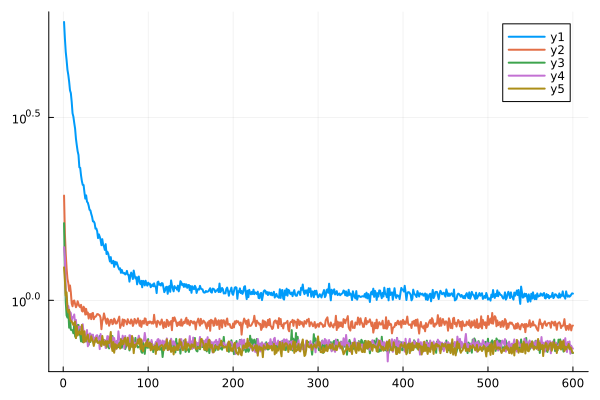

In [28]:
plot(lls[1], lw=2.0, yaxis=:log10)
plot!(lls[2], lw=2.0, yaxis=:log10)
plot!(lls[5], lw=2.0, yaxis=:log10)
plot!(lls[8], lw=2.0, yaxis=:log10)
plot!(lls[10], lw=2.0, yaxis=:log10)

In [29]:
buffer = run_selfplay(p, model, 5, 0.0f0)

5-element Vector{Game}:
 Game([7, 5, 1, 4, 6, 9, 3, 2, 8], Vector{Float32}[[0.08984375, 0.0, 0.052734375, 0.0, 0.053710938, 0.0, 0.7216797, 0.0, 0.08203125], [0.037109375, 0.083984375, 0.22753906, 0.0009765625, 0.47460938, 0.0009765625, 0.0, 0.0029296875, 0.171875], [0.5410156, 0.0029296875, 0.0390625, 0.15917969, 0.0, 0.0009765625, 0.0, 0.01953125, 0.23730469], [0.0, 0.00390625, 0.0078125, 0.90527344, 0.0, 0.05078125, 0.0, 0.001953125, 0.030273438], [0.0, 0.0087890625, 0.034179688, 0.0, 0.0, 0.9316406, 0.0, 0.0029296875, 0.022460938], [0.0, 0.099609375, 0.06640625, 0.0, 0.0, 0.0, 0.0, 0.07421875, 0.7597656], [0.0, 0.11328125, 0.69433594, 0.0, 0.0, 0.0, 0.0, 0.19238281, 0.0], [0.0, 0.95703125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04296875, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]], 0, Float32[-0.41503906, 0.47460938, -0.1015625, 0.06542969, 0.016601562, 0.043945312, -0.03515625, 0.04296875, 0.0])
 Game([1, 5, 9, 2, 8, 7, 3, 6, 4], Vector{Float32}[[0.6972656, 0.0, 0.00390625, 0.0, 0.05

In [30]:
for it in 1:4
    show_state(hist2state(buffer[it].history, 3), 3)
end

------
|○|×|○|
------
|×|×|○|
------
|○|○|×|
------
------
|○|×|○|
------
|○|×|×|
------
|×|○|○|
------
------
|○|×|○|
------
|×|×|○|
------
|○|○|×|
------
------
|○|×|○|
------
|×|×|○|
------
|○|○|×|
------


In [1]:
using LinearAlgebra
using Flux

In [12]:
model = Chain(Dense(rand(Float32, 3,2)))

Chain(
  Dense(2 => 3),                        # 9 parameters
) 

In [3]:
m2 = Chain(Dense(rand(Float32, 3,2)))

Chain(
  Dense(2 => 3),                        # 9 parameters
) 

In [4]:
L = length(m2)

1

In [5]:
test = rand(Float32, 2)

2-element Vector{Float32}:
 0.62433666
 0.8550172

In [15]:
model(test)

3-element Vector{Float32}:
 0.44241434
 0.95735955
 0.62402385

In [14]:
ps, re0 = Flux.destructure(model) 

(Float32[0.6510828, 0.88135636, 0.02506107, 0.042010248, 0.4761266, 0.7115381, 0.0, 0.0, 0.0], Restructure(Chain, ..., 9))

In [8]:
pt, re1 = Flux.destructure(m2)

(Float32[0.6528002, 0.2771777, 0.8120253, 0.94542927, 0.51700056, 0.6419691, 0.0, 0.0, 0.0], Restructure(Chain, ..., 9))

In [9]:
ps2 = 0.8f0ps + 0.2f0pt

9-element Vector{Float32}:
 0.564337
 0.2180188
 0.9053264
 0.19461502
 0.8341769
 0.16411655
 0.0
 0.0
 0.0

In [10]:
model2 = re0(ps2)

Chain(
  Dense(2 => 3),                        # 9 parameters
) 

In [11]:
model2(test)

3-element Vector{Float32}:
 0.51873547
 0.8493527
 0.7055509